In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [7]:
train_data_dir = '../DL Face Recognition/DL_track_train'
val_data_dir = '../DL Face Recognition/DL_track_val'
batch_size=32

transform = transforms.Compose(
    [transforms.Resize(64),
     transforms.Grayscale(num_output_channels=3),
     transforms.RandomCrop(48),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(train_data_dir, 
                               transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
  
val_dataset = datasets.ImageFolder(val_data_dir, 
                               transform=transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [8]:
import pathlib
root=pathlib.Path(train_data_dir)
classes=sorted([i.name.split('/')[-1] for i in root.iterdir() if i.name.split('/')[-1] != '.DS_Store'], key=int)
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48']


In [9]:
# Image shape after Conv
# Formula: (W - F + 2P)/S + 1 Where W - input (48x48), F - filter size (3x3), P - padding (1), S stride (1)

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
# conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
# conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
# conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
# pool = nn.MaxPool2d(kernel_size=2)

conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
bn1 = nn.BatchNorm2d(num_features=64)
conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
bn2 = nn.BatchNorm2d(num_features=128)

relu = nn.ReLU()
pool = nn.MaxPool2d(kernel_size=2)

print(f'origin shape: {images.shape}')

x = conv1(images)
print(f'conv1: {x.shape}')
x = bn1(x)
print(f'bn1: {x.shape}')
x = relu(x)
print(f'relu1: {x.shape}')
x = pool(x)
print(f'pool: {x.shape}')
x = conv2(x)
print(f'conv2: {x.shape}')
x = bn2(x)
print(f'bn2: {x.shape}')
x = relu(x)
print(f'relu2: {x.shape}')
x = pool(x)
print(f'pool2: {x.shape}')

#batch size, channel, size (RxR)

origin shape: torch.Size([32, 3, 48, 48])
conv1: torch.Size([32, 64, 48, 48])
bn1: torch.Size([32, 64, 48, 48])
relu1: torch.Size([32, 64, 48, 48])
pool: torch.Size([32, 64, 24, 24])
conv2: torch.Size([32, 128, 24, 24])
bn2: torch.Size([32, 128, 24, 24])
relu2: torch.Size([32, 128, 24, 24])
pool2: torch.Size([32, 128, 12, 12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


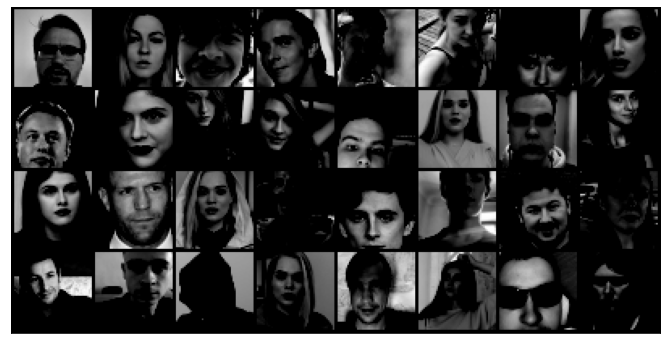

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break
        
show_batch(train_dataloader)

In [11]:
# CNN
class ConvNet(nn.Module):
    def __init__(self, num_classes=49):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1=nn.Linear(in_features=128*12*12, out_features=256)
        self.fc2=nn.Linear(in_features=256, out_features=num_classes)
        
    def forward(self, x):
        output=self.conv1(x)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)

        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
        output=self.pool2(output)

        output=output.view(-1, 128*12*12)
        output=self.fc1(output)
        output=self.fc2(output)
        return F.log_softmax(output, dim=1)

In [12]:
model=ConvNet(num_classes=49)
print(model)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=49, bias=True)
)


In [14]:
def train_nn(model, train_loader, val_loader, n_epochs):
    loss_function=nn.CrossEntropyLoss() #criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(n_epochs):
        #set CNN to training mode
        model.train()
        
        train_loss = 0.0
        train_accuracy = 0.0
        train_total = 0 #tracks total images
        
        for batch_num, (images, labels) in enumerate(train_loader):
            train_total += labels.size(0) #counts total images
            
            # set gradient to 0
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward() #backprog
            optimizer.step() 
            
            train_loss+= loss.cpu().data*images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_accuracy += int(torch.sum(prediction==labels.data))
            
        epoch_accuracy=train_accuracy/train_total
        epoch_loss=train_loss/train_total
        
       ####EVAL
            
        model.eval()
        
        val_accuracy = 0.0
        val_total = 0 #tracks total images
        
        for batch_num, (images, labels) in enumerate(val_loader):
            val_total += labels.size(0) #counts total images
            outputs = model(images)
            
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction==labels.data))
            
        val_accuracy=val_accuracy/val_total
        
        if (epoch+1)%10==0:
            print(f'Epoch {epoch+1} -- Train Loss: {epoch_loss :.2f} Train Acc: {epoch_accuracy*100 :.2f}% Val acc: {val_accuracy*100 :.2f}%')

    print("--Training complete--")
    

In [ ]:
train_nn(model, train_loader=train_dataloader, val_loader=val_dataloader, n_epochs=100)

Epoch 10 -- Train Loss: 0.23 Train Acc: 92.98% Val acc: 63.53%
Epoch 20 -- Train Loss: 0.19 Train Acc: 94.35% Val acc: 65.22%
Epoch 30 -- Train Loss: 0.22 Train Acc: 93.22% Val acc: 64.49%
Epoch 40 -- Train Loss: 0.19 Train Acc: 94.19% Val acc: 64.98%
Epoch 50 -- Train Loss: 0.21 Train Acc: 93.14% Val acc: 62.56%
Epoch 60 -- Train Loss: 0.23 Train Acc: 91.44% Val acc: 63.04%
Epoch 70 -- Train Loss: 0.16 Train Acc: 94.59% Val acc: 63.53%
Epoch 80 -- Train Loss: 0.22 Train Acc: 93.54% Val acc: 67.39%


In [ ]:
torch.save(model.state_dict(), 'DLFaceRecCNN3.pt')

In [ ]:
import os
import pandas as pd
import warnings
from torch.autograd import Variable
from PIL import Image
warnings.filterwarnings("ignore")

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.Resize(64),
     transforms.RandomCrop(48),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
model.eval()

directory = '../DL Face Recognition/DL_track_test'

df = pd.DataFrame(columns =['img_name', 'pred_class'])
count = 0
total = 22060 #total testing from kaggle

for filename in os.listdir(directory):
    if filename != '.DS_Store':
        f = str(os.path.join(directory, filename))

        count += 1
        if count%200==0:
            print(f'Image {count} -- Complete -- [{count}/{total} ({100*count/total :.2f}%)]')

        img = Image.open(directory+'/'+filename)
        img_test=transform(img)
        img_test=img_test.unsqueeze(0)
        img_test= Variable(img_test)
        res = model(img_test)
        pred = int(torch.argmax(res))
        insert_data = {'img_name': filename, 'pred_class':pred}
        df = df.append(insert_data, ignore_index=True)  
print('--Testing Completed!--')

df.head()

In [ ]:
import re

def extract_img_num(s):
    return re.search('image(.+?).png', s).group(1)

df['num'] = df['img_name'].apply(extract_img_num).astype(int)
df.head()

In [ ]:
df = df.sort_values(by='num').reset_index().drop(['index', 'num'], axis=1)
df.head()

In [ ]:
df.to_csv('submission.csv', index=False)